# Computing vibronic Hamiltonian in the many-body (TD-DFTB or TD-DFT) basis

In [1]:
import os, sys, time, math, cmath
import numpy as np
import matplotlib.pyplot as plt
import multiprocessing as mp

if sys.platform=="cygwin":
    from cyglibra_core import *
elif sys.platform=="linux" or sys.platform=="linux2":
    from liblibra_core import *

from libra_py import units as units
from libra_py import influence_spectrum as infsp
from libra_py import data_visualize, data_conv, data_read, data_stat, data_outs
from libra_py.workflows.nbra import mapping, step2_many_body, step3, step4, step3_many_body

/home/alexey/Conda/Miniconda3/envs/libra/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, std::allocator<int> > > > already registered; second conversion method ignored.
  return f(*args, **kwds)
/home/alexey/Conda/Miniconda3/envs/libra/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for boost::python::detail::container_element<std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, std::allocator<int> > > >, unsigned long, boost::python::detail::final_vector_derived_policies<std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, std::allocator<int> > > >, false> > already registered; second conversion method ignored.
  return f(*args, **kwds)
/home/alexey/Conda/Miniconda3/envs/libra/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for std::vector<std::v

In [2]:
%%time

path = os.getcwd()
params = { "data_set_paths": [ F"{path}/res/"],
           "logfile_directory":F"{path}/all_logfiles",
           "read_S_data" : 1, "read_S_re":1,  "read_S_im":0,
           "S_data_re_prefix": "S_ks_",  "S_data_re_suffix": "_re",
           "S_data_im_prefix": "S_ks_",  "S_data_im_suffix": "_im",
           "read_St_data" : 1, "read_St_re":1,  "read_St_im":0,
           "St_data_re_prefix": "St_ks_",  "St_data_re_suffix": "_re",
           "St_data_im_prefix": "St_ks_",  "St_data_im_suffix": "_im",
           "read_hvib_data" : 1, "read_hvib_re":1,  "read_hvib_im":0,
           "hvib_data_re_prefix": "E_ks_",  "hvib_data_re_suffix": "_re",
           "hvib_data_im_prefix": "E_ks_",  "hvib_data_im_suffix": "_im",
           "isnap":5000, "fsnap":7000, 
           "data_dim":42, "active_space":range(0,int(42/2)), 
           "orbital_indices":list( range(150, 170) ), "homo_index":160,
           "es_software":"cp2k", "isUKS":0, "tolerance":0.01, "number_of_states":15,
           "orbital_normalization":True, "orbital_phase_correction":True,
           "state_normalization":True, "state_phase_correction":True,
           "do_state_reordering":2, "state_reordering_alpha":0,
           "verbosity":0,
           "sorting_type":"identity", "dt": 1.0*units.fs2au,
           "outdir":F"{path}/res_mb_sp/" }

Hvib = step3_many_body.run(params)

number of steps , nsteps=  1999
Output the CI data to the res directory...
CPU times: user 14min 20s, sys: 12.1 s, total: 14min 32s
Wall time: 16min 17s


In [3]:
ntraj  = len(Hvib)
nsteps = len(Hvib[0])
nCIs   = Hvib[0][0].num_of_cols

print(ntraj, nsteps, nCIs)

1 2000 16


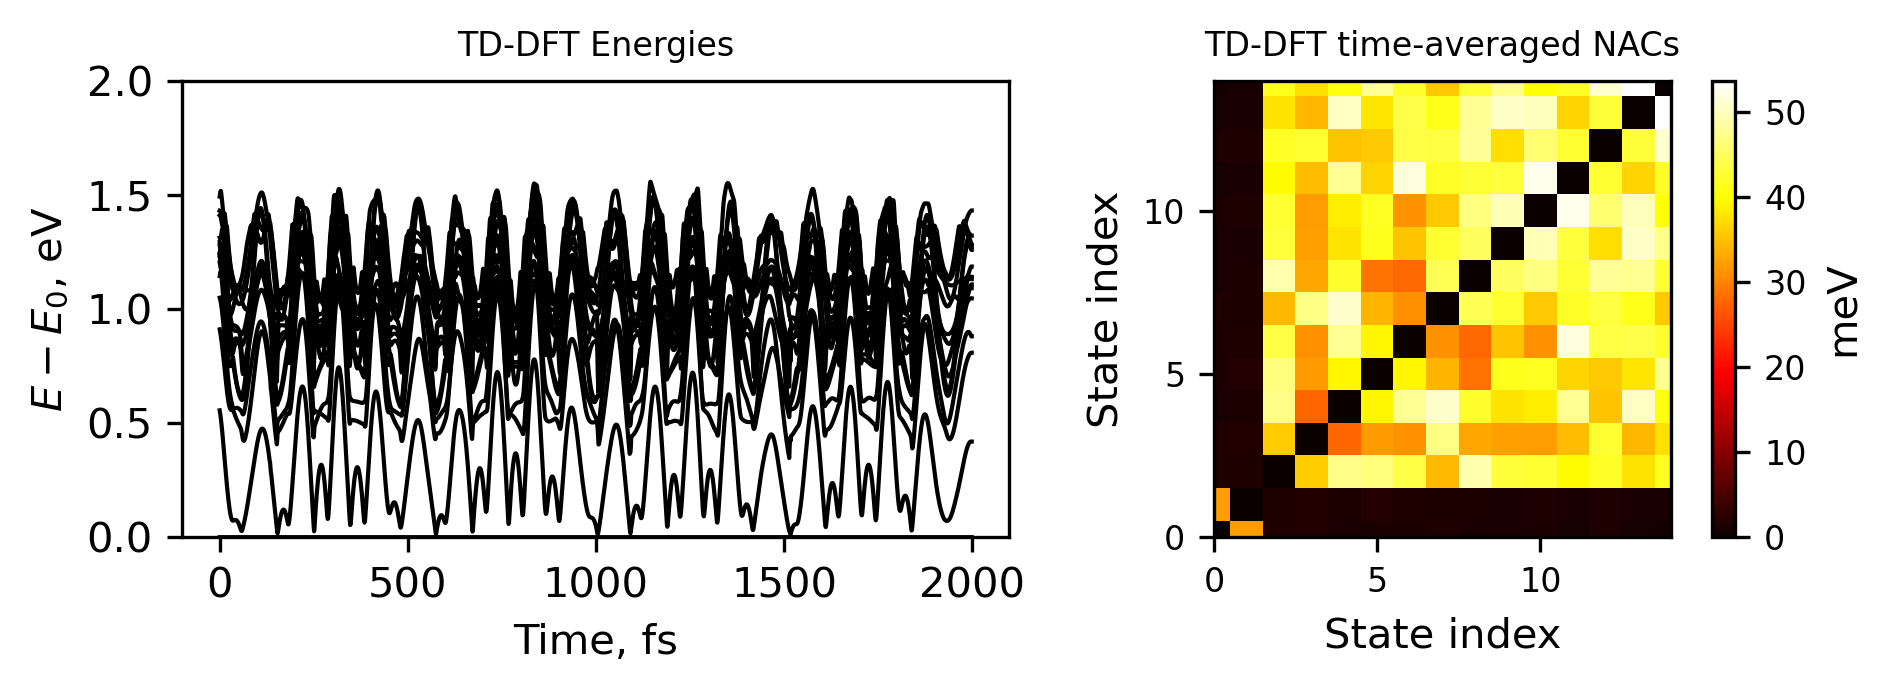

In [6]:
ntraj  = len(Hvib)
nsteps = len(Hvib[0])
nCIs   = Hvib[0][0].num_of_cols

# Make a list for the SD energies and populate it
CI_energy = []
md_time = list( range(nsteps) )
for sd_index in range( nCIs ):
    CI_energy.append( [] )
    for step in range( nsteps ):        
        En = Hvib[0][step].get( sd_index, sd_index ).real 
        E0 = Hvib[0][step].get( 0, 0 ).real
        CI_energy[ sd_index ].append( En - E0 )        
        
CI_energy  = np.array( CI_energy  )
md_time    = np.array( md_time )

# Compute the time-averaged CI NACs and make a list of them
ci_res = data_stat.cmat_stat2(Hvib[0], 2)
ci_tNACs = []
for i in range(nCIs):
    ci_tNACs.append( [] )
    for j in range(nCIs):
        ci_tNACs[i].append( ci_res.get(i,j).imag * 1000.0 / units.ev2Ha )        
ci_tNACs = np.array(ci_tNACs)


nstates = 15

# Figures - Time-Dependent Data
plt.figure(num=None, figsize=(6.42, 2.41), dpi=300, edgecolor='black', frameon=True)
plt.subplot(1,2,1)
plt.ylim(0,2)
plt.title('TD-DFT Energies', fontsize=8)
plt.xlabel('Time, fs')
plt.ylabel('$E-E_0$, eV')
for state in range( nstates ):    
    plt.plot(md_time, CI_energy[state]/units.ev2Ha, label="", linewidth=1, color = "black")
plt.tight_layout()


plt.subplot(1,2,2)
plt.title('TD-DFT time-averaged NACs', fontsize=8)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.xlim(0,nstates-1)
plt.ylim(0,nstates-1)
#plt.xticks([0,1,2,3,4,5,6,7,8,9])
#plt.yticks([0,1,2,3,4,5,6,7,8,9])
plt.xlabel('State index')
plt.ylabel('State index')
plt.imshow(ci_tNACs, cmap='hot', interpolation='nearest')
cb = plt.colorbar(label="meV")
cb.ax.tick_params(labelsize=8)

plt.tight_layout()

plt.savefig('energies_nacs.png', dpi=300)
plt.show()

